In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def varstats_evol(ds, var_name, duration_type):
    """
    return mean, std values (std error) of hourly varaible from tracks
    """

    meanval = ds[var_name].mean('tracks')
    stdval = ds[var_name].std('tracks')/np.sqrt(len(ds.tracks))

    return meanval, stdval

In [4]:
# PNNL 3-deg mean variables, mcs_era5_mean_envs_20060101.0000_20070101.0000.nc
envmcs_dir = Path('/neelin2020/mcs_flextrkr/era5_envs/')
# MCS tracks: landsea info, duration type
track_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase/')

year = 2015
ds_env = xr.open_dataset(envmcs_dir / 'mcs_era5_mean_envs_{}0101.0000_{}0101.0000.nc'.format(year,year+1))
ds_track = xr.open_dataset(track_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.MCSphaseDtype.nc'.format(year))
ds_info = xr.open_dataset(track_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
ds_fulltrack = xr.open_dataset(track_dir / '../mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))

# MCS dtype
ds_mean = []
ds_stderr = []

for dtype in ['SL','ML','LL','UL']:
    
    dtype_info = ds_track.duration_type
    idx = np.where(dtype_info == dtype)[0]
    ds_sub = ds_env.isel(tracks=idx) # get enviromental vars of selected tracks
    ds_sub = ds_sub.where(ds_sub != -999, np.NaN)
    mean_val = ds_sub.mean('tracks')
    stderr_val = ds_sub.std('tracks')/np.sqrt(len(ds_sub.tracks)) 

    ds_mean.append(mean_val)
    ds_stderr.append(stderr_val)

# concatenate all types
ds_mean_Dtypes = xr.concat(ds_mean, dim=pd.Index(['SL','ML','LL','UL'], name='duration_type'))
ds_stderr_Dtypes = xr.concat(ds_stderr, dim=pd.Index(['SL','ML','LL','UL'], name='duration_type'))

### MCS features
- size, core fraction, precip features, etc.
- BL area, blobs, etc

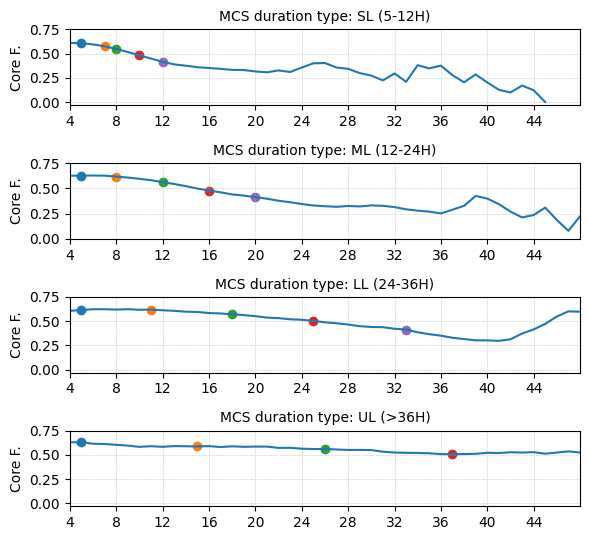

In [30]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(6,5.5))
#var_name = 'corecold_meantb'

for i,(dtype,ax,dtype_str) in enumerate(zip(['SL','ML','LL','UL'],[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)'])):
    
    dtype_info = ds_track.duration_type
    idx = np.where(dtype_info == dtype)[0]
    tmp = ds_fulltrack['core_area'].isel(tracks=idx).mean('tracks')
    tmp2 = ds_fulltrack['ccs_area'].isel(tracks=idx).mean('tracks')
    tmp3 = tmp/tmp2
    cp = ax.plot(tmp.times, tmp3)
    ax.set_ylabel('Core F.',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype_str), fontsize=10)

    # plot mean MCS stage time points
    idt_mcs_init = ds_fulltrack['idt_mcs_init'].isel(tracks=idx).mean('tracks').round().astype('int')
    idt_mcs_grow = ds_fulltrack['idt_mcs_grow'].isel(tracks=idx).mean('tracks').round().astype('int')
    idt_mcs_mature = ds_fulltrack['idt_mcs_mature'].isel(tracks=idx).mean('tracks').round().astype('int')
    idt_mcs_decay = ds_fulltrack['idt_mcs_decay'].isel(tracks=idx).mean('tracks').round().astype('int')
    idt_mcs_end = ds_fulltrack['idt_mcs_end'].isel(tracks=idx).mean('tracks').round().astype('int')

    ax.scatter(tmp.times[idt_mcs_init], tmp3[idt_mcs_init])
    ax.scatter(tmp.times[idt_mcs_grow], tmp3[idt_mcs_grow])
    ax.scatter(tmp.times[idt_mcs_mature], tmp3[idt_mcs_mature])
    ax.scatter(tmp.times[idt_mcs_decay], tmp3[idt_mcs_decay])
    ax.scatter(tmp.times[idt_mcs_end], tmp3[idt_mcs_end])

    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_yticks(np.arange(0,1,0.25))
    ax.set_xticks(np.arange(0,48,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([4,48])
ax2.set_xlim([4,48])
ax3.set_xlim([4,48])
ax4.set_xlim([4,48])
plt.tight_layout()

array([3])

### Environmental factors 

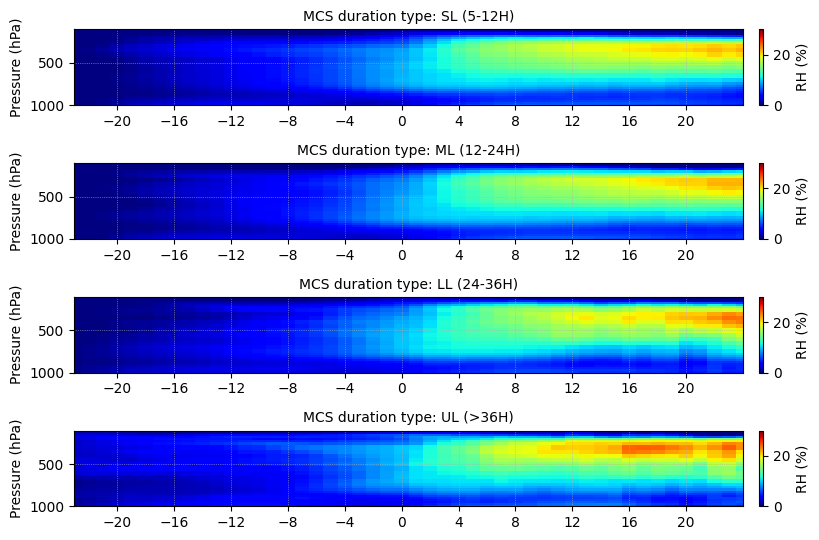

In [101]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.R.isel(duration_type=i)
    tmp2 = (tmp - climat_val.R)
    cp = ax.pcolormesh(tmp2.rel_times, tmp.level, tmp2.T, vmin=0,vmax=30,cmap='jet')
    cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    cbar.set_label('RH (%)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([1000,100])
    ax.set_xticks(np.arange(-24,24,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

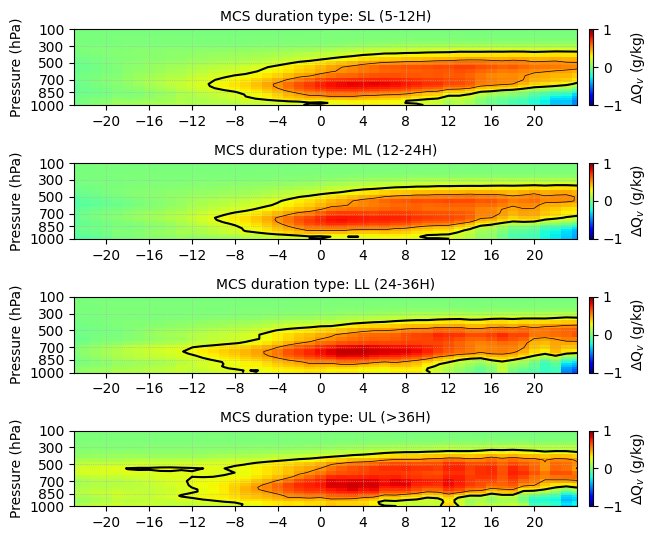

In [104]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(7,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.Q.isel(duration_type=i)
    tmp2 = 1000*(tmp - climat_val.Q)
    cp = ax.pcolormesh(tmp2.rel_times, tmp.level, tmp2.T, vmin=-1,vmax=1,cmap='jet')
    cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    cbar.set_label('$\Delta$Q$_{v}$ (g/kg)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([1000,100])
    ax.set_xticks(np.arange(-24,24,4))
    ax.set_yticks([1000,850,700,500,300,100])
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

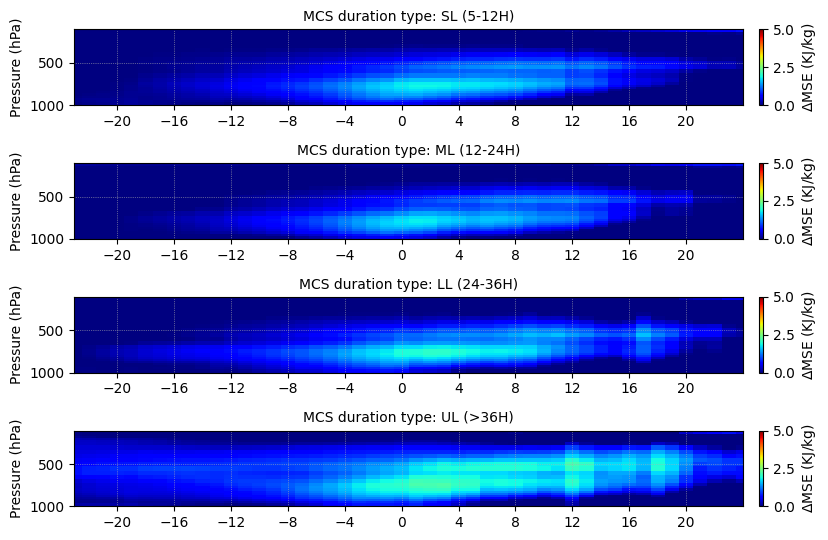

In [75]:
# MSE value
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.T.isel(duration_type=i)*1004 + 2.5e6*ds_mean_Dtypes.Q.isel(duration_type=i) + ds_mean_Dtypes.Z.isel(duration_type=i)
    tmp2 = (tmp - (1004*climat_val.T + 2.5e6*climat_val.Q + climat_val.Z))
    cp = ax.pcolormesh(tmp2.rel_times, tmp.level, tmp2.T/1000, vmin=0, vmax=5, cmap='jet')
    cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    cbar.set_label('$\Delta$MSE (KJ/kg)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2.level, tmp2.T, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([1000,100])
    ax.set_xticks(np.arange(-24,24,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

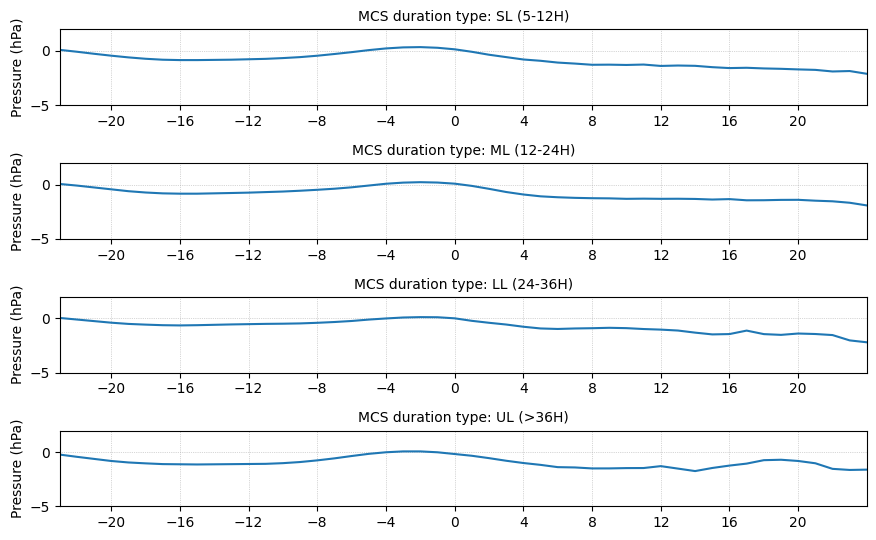

In [82]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.SKT.isel(duration_type=i)
    tmp2 = (tmp - climat_val.SKT)
    cp = ax.plot(tmp2.rel_times, tmp2)
    #cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    #cbar.set_label('$\Delta$Q$_{v}$ (g/kg)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([-5,2])
    ax.set_xticks(np.arange(-24,24,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

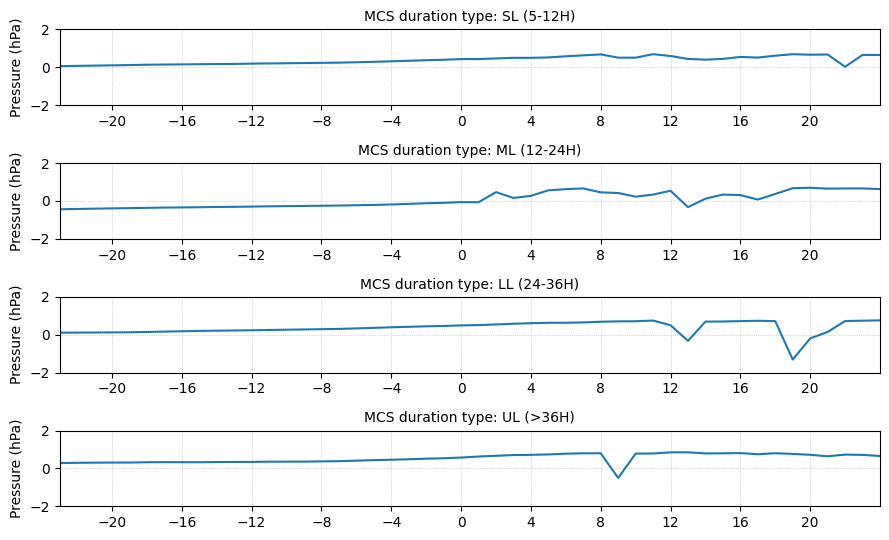

In [99]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.q_500mb.isel(duration_type=i)
    tmp2 = (tmp - climat_val.q_500mb)
    cp = ax.plot(tmp2.rel_times, tmp2)
    #cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    #cbar.set_label('$\Delta$Q$_{v}$ (g/kg)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([-2,2])
    ax.set_xticks(np.arange(-24,24,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

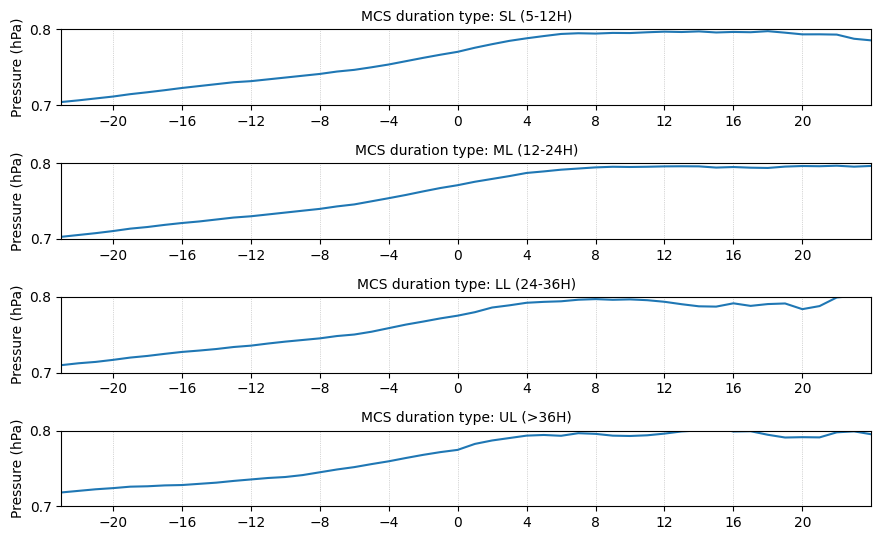

In [34]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,5.5))

climat_val = ds_mean_Dtypes.mean('duration_type').isel(rel_times=0)

for i,ax,dtype in zip(range(4),[ax1,ax2,ax3,ax4],['SL (5-12H)','ML (12-24H)','LL (24-36H)', 'UL (>36H)']):
    tmp = ds_mean_Dtypes.CSF.isel(duration_type=i)
    #tmp2 = (tmp - climat_val.CSF)
    cp = ax.plot(tmp2.rel_times, tmp)
    #cbar = plt.colorbar(cp,ax=ax,pad=0.02)
    #cbar.set_label('$\Delta$Q$_{v}$ (g/kg)', fontsize=10)
    ax.set_ylabel('Pressure (hPa)',fontsize=10)
    ax.set_title('MCS duration type: {}'.format(dtype), fontsize=10)
    if i < 3:
        ax.set_xticks([])
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25,0.5,1,1.25,1.5], colors=['k'], linewidths=0.5)
    #ax.contour(tmp2.rel_times, tmp2, levels=[0.25], colors=['k'], linewidths=1.5)
    ax.set_ylim([0.7,0.8])
    ax.set_xticks(np.arange(-24,24,4))
    ax.grid(ls=':',lw=0.5)

ax1.set_xlim([-23,24])
ax2.set_xlim([-23,24])
ax3.set_xlim([-23,24])
ax4.set_xlim([-23,24])
plt.tight_layout()

In [36]:
for year in np.arange(2001,2021):
    files = list(Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_2D'.format(year)).glob('*mpr*'))
    if len(files) == 1:
        print('{} ... ok!'.format(year))
    else:
        print('{} ...missing files'.format(year))

2001 ... ok!
2002 ... ok!
2003 ... ok!
2004 ... ok!
2005 ... ok!
2006 ... ok!
2007 ... ok!
2008 ... ok!
2009 ... ok!
2010 ... ok!
2011 ... ok!
2012 ... ok!
2013 ... ok!
2014 ... ok!
2015 ... ok!
2016 ... ok!
2017 ... ok!
2018 ... ok!
2019 ... ok!
2020 ... ok!
